# VMI-Kas: Why forest growth rate is decreasing in Finland?

### Notes on inter-annual variability and trends in meteorological conditions and abiotic growth factors

### Samuli Launiainen & Olli-Pekka Tikkasalo Nov 4th, 2022

In [1]:
# import modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.stats import linregress
from IPython.display import Image

# module containing plotting functions, trend analysis etc. for this task
import growth_factors as gf


## Hydrological simulations for generic coniferous stands using SpaFHy (*Launiainen et al. 2019*)

### Simulations represent a generic mature coniferous forest (pine/spruce) with following properties:

1. leaf-area index LAI 4.0 m2m-2 + understory 0.5 m2m-2
1. Four site fertility types: herb-rich (), mesic, sub-xeric & xeric, which differ in their soil hydraulic properties as in *Launiainen et al. (2022)*.

### The approach:

1. Daily weather data from FMI's 10x10 km grid (1980 - 2016) and 1 x 1 km grid (2016-). Variables: global radiation (Rg), air temperature (T), air relative humidity (RH), vapor pressure deficit (VPD) and precipitation (P). 

1. Weather data was spatially averaged over Southern and Northern Finland (Kainuu, Pohjois-Pohjanmaa, Lappi).

1. SpaFHy parameters as in *Launiainen et al. (2019)*, with except of site-type specific water-retention properties (porosity, field capacity (*FC*), wilting point (*WP*), water-retention curve. Those were recently summarized for Finnish mineal soils in the recent MaaTi-project (*Launiainen et al. 2022).*

1. Effective root zone depth (*Droot*) set to 35 cm. Thus, plant available water capacity (mm of water) that can be retained in the root zone was *AWC = (FC - WP) * Droot*.

1. Soil moisture restricition for stomatal conductance (*fW*) in *Launiainen et al. (2019)* was replaced with a more physiologically based from *Zhou et al. (2013)*: *fW =  exp(-b * Psi_s)*, where *Psi_s* (MPa) is soil water potential, and *b* (MPa-1) a parameter. Based on *Zhou et al (2013* *b~0.6* on average for gymnosperm trees, while *Launiainen et al. (2015)* estimate *b~0.7* for Scots pine. 

1. Simulations for 1980 - 2021 period. Model spin-up by looping 1980 twice.

### Studied (daily) model outputs:

1. Snow water equivalent *SWE* (mm)

1. Volumetric soil moisture content *Wliq* (m3m-3)

1. Relative plant available water *Rew = min[1.0, (Wliq - WP) / (FC - WP)]*. *Rew* represents the fraction of *AWC* that is available for plants.

1. Stomatal conductance soil moisture modifier *fW*


In [2]:
# read weather data & model results: They are pd.DataFrame in two pickle files:

# southern finland
with open(r'results/southern_finland_1981_2021.pk', 'rb') as f:
    sf = pickle.load(f)
    sf = sf[sf.index.year > 1980]
# northern finland
with open(r'results/northern_finland_1981_2021.pk', 'rb') as f:
    nf = pickle.load(f)
    nf = nf[nf.index.year > 1980]

print('rows, col: ', sf.shape, nf.shape)
#print('columns: ', sf.columns.to_list())
sf.head()

rows, col:  (14975, 42) (14975, 38)


,doy,Rg,Par,T,Tmin,Tmax,Prec,h2o,VPD,CO2,U,dds,SWE,Wliq_herb_rich,Psi_herb_rich,ET_herb_rich,Transpi_herb_rich,fW_herb_rich,fQ_herb_rich,Wliq_mesic,Psi_mesic,ET_mesic,Transpi_mesic,fW_mesic,fQ_mesic,Wliq_sub_xeric,Psi_sub-xeric,ET_sub_xeric,Transpi_sub_xeric,fW_sub_xeric,fQ_sub_xeric,Wliq_xeric,Psi_xeric,ET_xeric,Transpi_xeric,fW_xeric,fQ_xeric,Rew_herb_rich,Rew_mesic,Psi_sub_xeric,Rew_sub_xeric,Rew_xeric
1981-01-01,1,4.843216,2.421608,-3.285077,-13.551,3.900,1.451211e-05,0.458203,0.021792,400.0,2.0,0.0,124.338936,0.462433,-0.000763,0.000449,0.000449,0.999521,0.043511,0.358792,-0.001767,0.000448,0.000448,0.998893,0.043511,0.271139,NaN,0.000448,0.000448,0.997309,0.043511,0.159184,-0.005084,0.000447,0.000447,0.996818,0.043511,1.0,1.0,-0.004300,1.0,1.0
1981-01-02,2,5.458814,2.729407,-7.489846,-18.900,0.700,5.460589e-07,0.314523,0.034334,400.0,2.0,0.0,124.385963,0.462181,-0.000766,0.000603,0.000603,0.999519,0.048946,0.358439,-0.001777,0.000602,0.000602,0.998887,0.048946,0.270804,NaN,0.000601,0.000601,0.997294,0.048946,0.158930,-0.005108,0.000601,0.000601,0.996802,0.048946,1.0,1.0,-0.004323,1.0,1.0
1981-01-03,3,5.471973,2.735986,-7.588974,-18.651,0.400,1.568732e-05,0.322357,0.023837,400.0,2.0,0.0,125.737106,0.461931,-0.000769,0.000509,0.000509,0.999518,0.049062,0.358090,-0.001786,0.000509,0.000509,0.998881,0.049062,0.270474,NaN,0.000508,0.000508,0.997280,0.049062,0.158679,-0.005132,0.000508,0.000508,0.996787,0.049062,1.0,1.0,-0.004346,1.0,1.0
1981-01-04,4,6.049252,3.024626,-11.006205,-21.351,-0.749,1.454179e-06,0.248367,0.016421,400.0,2.0,0.0,125.862366,0.461683,-0.000772,0.000465,0.000465,0.999516,0.054138,0.357746,-0.001795,0.000465,0.000465,0.998875,0.054138,0.270148,NaN,0.000464,0.000464,0.997266,0.054138,0.158432,-0.005156,0.000464,0.000464,0.996772,0.054138,1.0,1.0,-0.004368,1.0,1.0
1981-01-05,5,7.079529,3.539764,-16.406667,-27.400,-5.000,9.496676e-08,0.148695,0.021821,400.0,2.0,0.0,125.870552,0.461437,-0.000775,0.000592,0.000592,0.999514,0.063153,0.357406,-0.001805,0.000591,0.000591,0.998870,0.063153,0.269827,NaN,0.000590,0.000590,0.997252,0.063153,0.158188,-0.005180,0.000590,0.000590,0.996757,0.063153,1.0,1.0,-0.004391,1.0,1.0


### Thermal growing season (*gs*) start, end and duration from weather data following *Linderholm (2006)*
### "*thermal gs start is the first day when daily mean temperature > 5C for five days in a row."*

1. We see no change in *gs start* in Southern Finland, marginally earlier onset in Northern Finland.

1. Autumns are getting warmer and thermal *gs end* delayed; this explains why *gs length* is increasing

1. Does Spruce as shade species with weaker winter dormancy / faster spring recovery (e.g. *Linkosalo et al. 201x*) benefit more from changes in growing season edges?

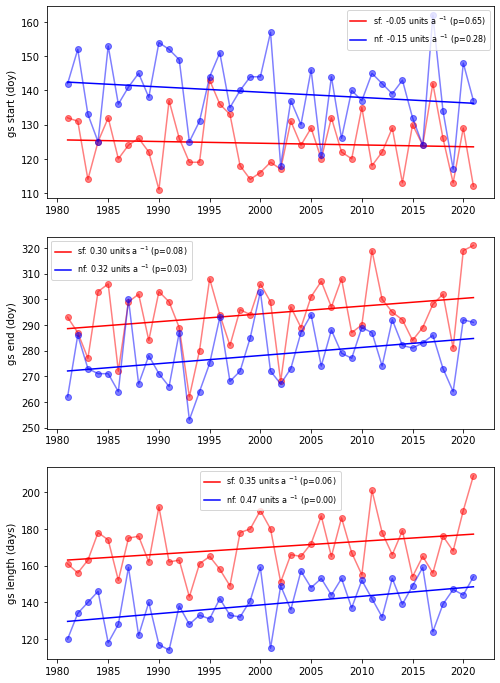

In [3]:
thermal_gs = {'sf': gf.thermal_growingseason(sf),
              'nf': gf.thermal_growingseason(nf)
             }
cols = thermal_gs['sf'].columns
ytext = ['gs start (doy)', 'gs end (doy)', 'gs length (days)']

fig1 = gf.plot_trends(thermal_gs, cols, ytext)

__Fig. 1:__ Thermal growing season changes in Southern (sf) and Northern (nf) Finland. From FMI grid-data following *Linderholm 2006*.

### Snow (modeled, from SpaFHy)
1. Quality of Precipitation depends on *T*
1. Snow melt based on degree-day melt model corrected with canopy shading


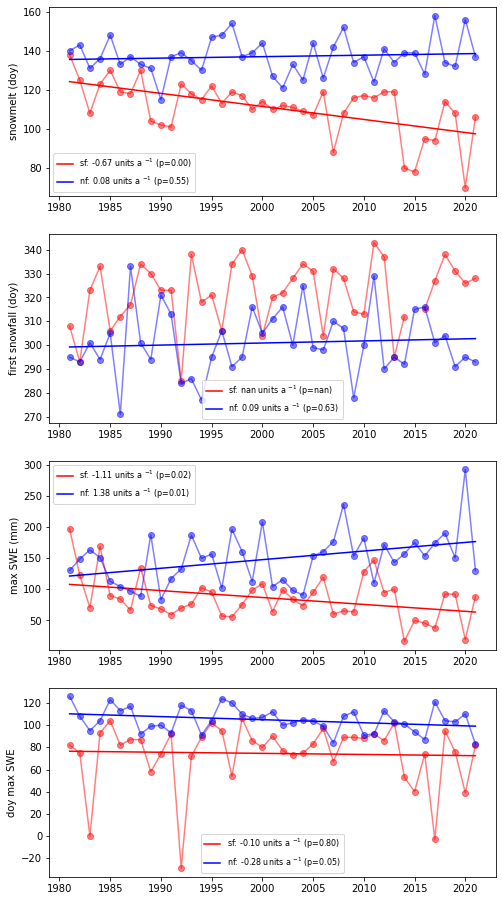

In [4]:
# compute snow statistics
snow = {'sf': gf.snowmelt_doy(sf),
              'nf': gf.snowmelt_doy(nf)
             }
cols = snow['sf'].columns
ytext = ['snowmelt (doy)', 'first snowfall (doy)', 'max SWE (mm)', 'doy max SWE']

fig2 = gf.plot_trends(snow, cols, ytext)

__Fig 2:__ Snowpack. Annual maximum snow water equivalent (max *SWE*) decreasing significantly in Southern Finland and increasing in Northern Finland, in line with winter precipitation and temperature trends (Fig.x). Max *SWE* is occurring earlier than before in Northern Finland (negative doy = days before 1.1.). Strong negative trend in snowmelt date in Southern Finland, with impacts on soil water dynamics (Fig. x). Earlier snowmelt may increase risks for early-summer droughts if springs are dry.

### Temperature, precipitation, global radiation and VPD

1. Annual averages
1. Thermal growing season average
1. July-August average

In [5]:
#import growth_factors as gf

# Annual means / sums
adata = {'sf': gf.compute_period_stats(sf, thermal_gs['sf'], fdoy=1, ldoy=365),
              'nf': gf.compute_period_stats(nf, thermal_gs['nf'], fdoy=1, ldoy=365)
             }
# Thermal gs means/sums
gsdata = {'sf': gf.compute_period_stats(sf, thermal_gs['sf']),
              'nf': gf.compute_period_stats(nf, thermal_gs['nf'])
             }

# July-August means/sums (most risky period for droughts)
jadata = {'sf': gf.compute_period_stats(sf, thermal_gs['sf'],fdoy=182, ldoy=243),
              'nf': gf.compute_period_stats(nf, thermal_gs['nf'],fdoy=182, ldoy=243)
             }

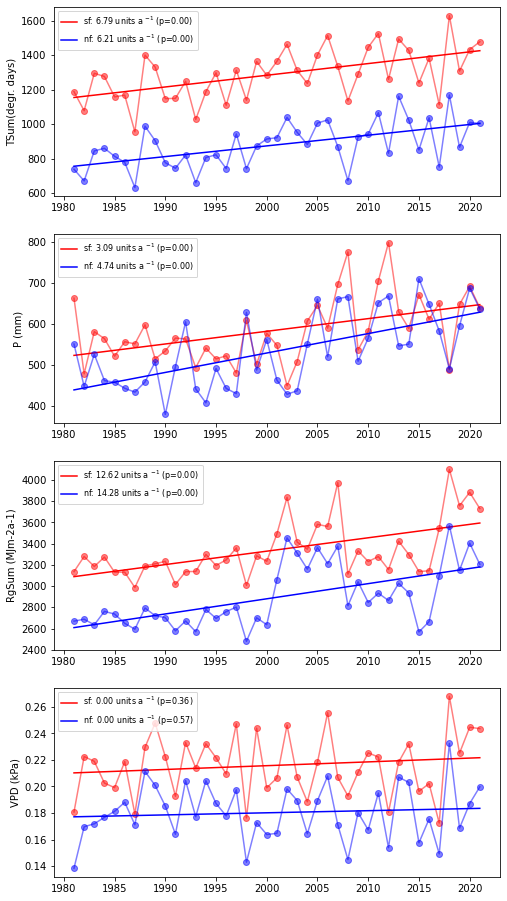

In [6]:
# plot data and add linear trendlines
cols = ['TSum', 'PrecSum', 'RgSum', 'VPD']
ytext = ['TSum(degr. days)', 'P (mm)', 'RgSum (MJm-2a-1)', 'VPD (kPa)']
fig3 = gf.plot_trends(adata, cols, ytext)

__Fig 3:__ Annual IAV & trends. Wonder if Precip trend is true or is there something fishy in FMI grid data pre-2000?

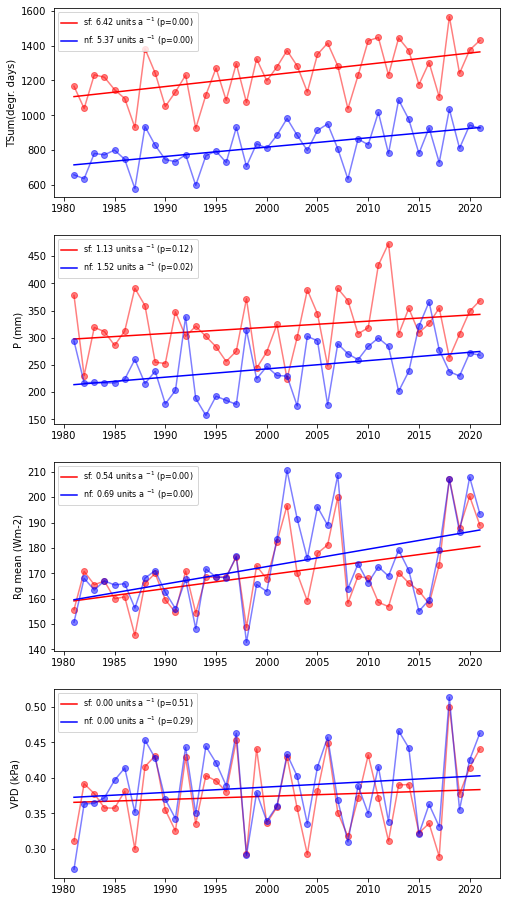

In [7]:
cols = ['TSum', 'PrecSum', 'Rg', 'VPD']
ytext = ['TSum(degr. days)', 'P (mm)', 'Rg mean (Wm-2)', 'VPD (kPa)']

fig4 = gf.plot_trends(gsdata, cols, ytext)

__Fig 4:__ IAV & trends in thermal growing season. *Rg mean* is average global radiation.

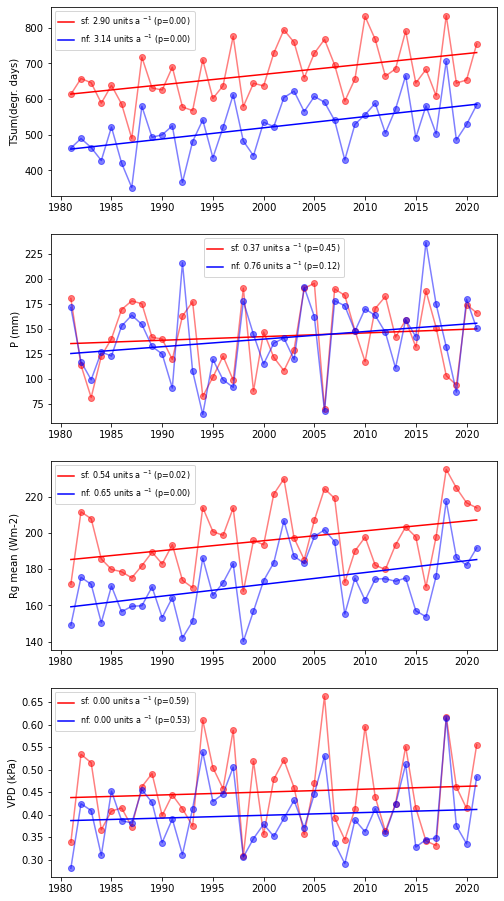

In [8]:
cols = ['TSum', 'PrecSum', 'Rg', 'VPD']
ytext = ['TSum(degr. days)', 'P (mm)', 'Rg mean (Wm-2)', 'VPD (kPa)']

fig5 = gf.plot_trends(jadata, cols, ytext)

__FIG 5:__ July-August IAV & trends. No change in *P* or *VPD* but positive trend in Global radiation. 

## SpaFHy -simulations of soil moisture

1. Thermal growing season and July-August averages
1. Seasonal cycles (2 week averages)

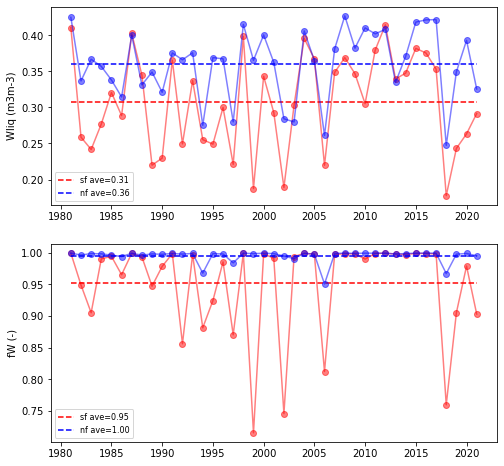

In [9]:

cols = ['Wliq_mesic', 'fW_mesic']
ytext = ['Wliq (m3m-3)', 'fW (-)']

fig6 = gf.plot_trends(gsdata, cols, ytext, trends=False, means=True)

__Fig.6:__ Growing-season average root zone vol. moisture content (m3m-3) at mesic sites in Southern (red) and Northern (blue) Finland. The water modifier *fW* below 1 may indicate soil water limitations. The dashed lines are long-term averages.

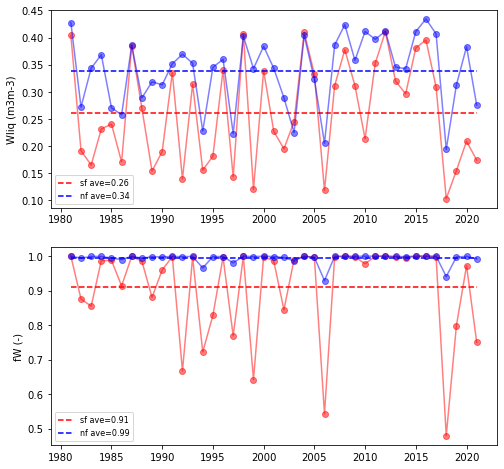

In [10]:
fig7 = gf.plot_trends(jadata, cols, ytext, trends=False, means=True)

__Fig.7:__ As Fig. 6 but for July-August -period. We see potential water limitations (*fW<1*) in 2018, 2019 & 2020; note long moist period from 2007 to 2017!

## Seasonal dynamics of soil moisture, precipitation and temperature

## Southern Finland

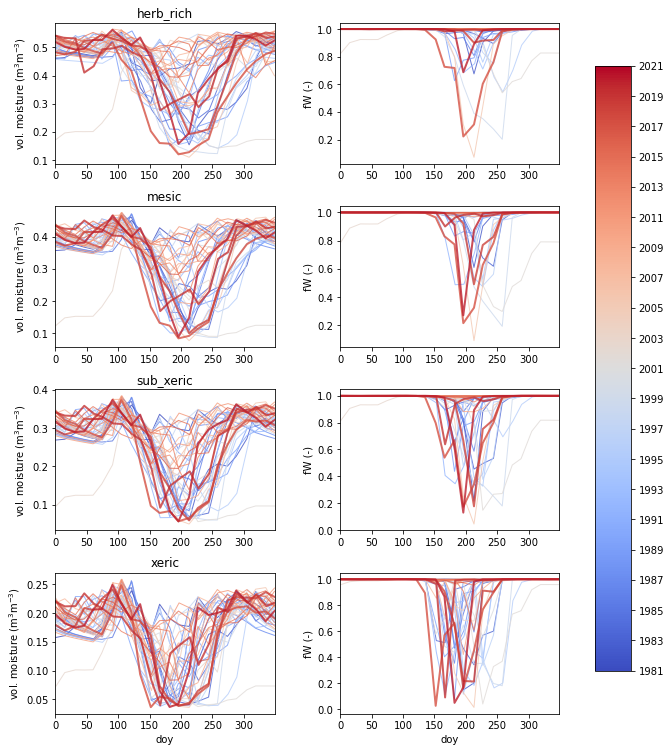

In [11]:
# compute and plot half-monthly averaged soil moisture and fW cycles
#import growth_factors as gf
ave2ws, yrs = gf.temporal_averages_by_year(sf, window='SMS')
fig8 = gf.make_seasonal_course_soilmoisture(ave2ws, yrs)

__Fig. 8:__ Seasonal cycle of soil moisture in Southern Finland (left), and potential water limitations (right) at different site types. Years 2018--> shown by __thick lines__. Note how earlier snowmelt affects spring soil moisture, and how recent years (2018, 2021) have been dry already in June. The water limitations become more severe at sub-xeric and xeric site due to their poorer water-holding capacity; see also *Launiainen et al. (2022)*. The moist period 2007-2017 is seen as relatively high *Wliq* and absense of water limitations throughout the summer.

## Northern Finland

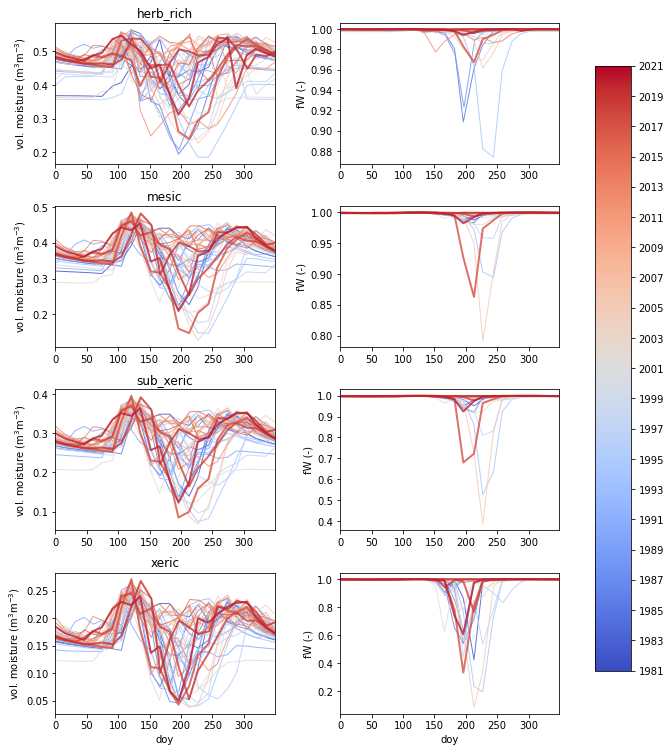

In [12]:
# compute and plot half-monthly averaged soil moisture and fW cycles
import growth_factors as gf
ave2wn, yrs = gf.temporal_averages_by_year(nf, window='SMS')
fig8 = gf.make_seasonal_course_soilmoisture(ave2wn, yrs)

__Fig. 9:__ As Fig. 8 but for Northern Finland. Note the lesser water limitations than at Southern Finland.

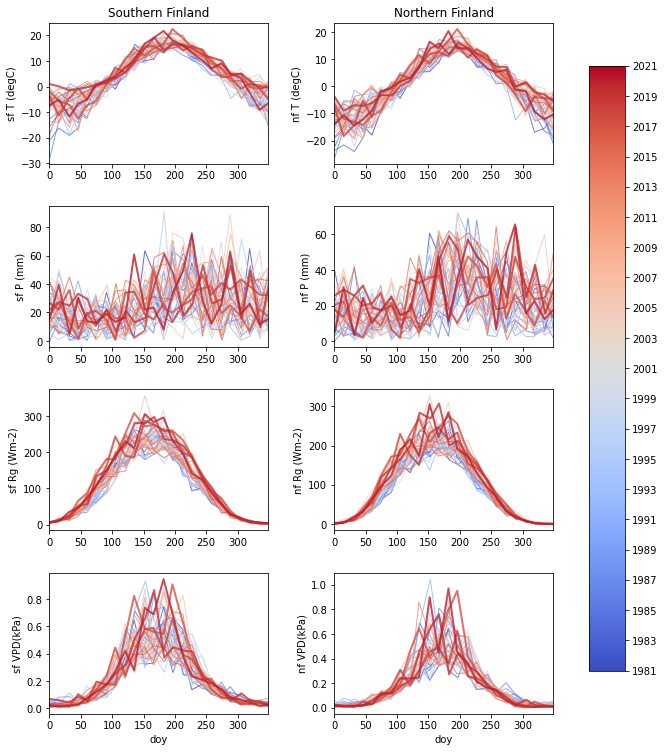

In [13]:
import growth_factors as gf
cols=['T', 'Prec', 'Rg', 'VPD']
ytext =  ['T (degC)', 'P (mm)', 'Rg (Wm-2)', 'VPD(kPa)']
fig10 = gf.make_seasonal_course_figure(ave2ws, ave2wn, yrs, cols, ytext)

__Fig. 10:__ Seasonal cycles of meteorological conditions in Southern & Northern Finland. Note several of the past 2018 years (in __bold__) among the warmest, driest and clearest all time.

### How site type and forest density may affect drought risks?

![Launiainen2022_fig9](results/Launiainen_2022Forests_Fig9.PNG)

__Fig. 11:__ Example of how soil moisture restriction *fW* may vary across site types and forest density (here via leaf-area index). 15 year simulation for Paunulanpuro, Orivesi (2000-2015). From *Launiainen et al. (2022)*. We note drought risks increase with decreasing site fertility (water holding capacity) and increasing LAI (more rainfall interception, less throughfall and higher transpiration rate).

## Hydrometeorological climate indices

### Indices computed from FMI grid data aggregated for Southern and Northern Finland using Python 'climate indices' package (*Adams, 2017*)

1. Standardised Precipitation Index, *SPI*

1. Standardised Precipitation-Evapotranspiration Index, *SPEI*

Standardoitua sadanta indeksiä (SPI) ja standardoitua sadanta-haihdunta indeksiä (SPEI) käytetään määrittäämään onko tietyllä aikajaksolla ollut tavanomaista kuivempaa tai kosteampaa. Indeksit lasketaan joko mitatusta sademäärästä (SPI) tai mitatusta sademäärästä ja keskilämpötilasta (SPEI). SPEI:n tapauksessa mitatusta keskilämpötilasta arvioidaan, kuinka paljon sataneesta vedestä haihtuu takaisin ilmaan. Tämä potentiaalinen haihdunta vähennetään mitatusta sademäärästä, jolloin saadaan arvio kuinka paljon sateesta jää puiden käytettäväksi. SPEI on siis kattavampi indeksi kuin SPI, sillä SPEI huomioi, että maaperän vesivarastoon vaikuttavat sekä siihen tulevan (sataneen) että lähtevän (haihtuneen) veden määrä. SPI huomioi ainoastaan tulevan (sataneen) veden.

Molempien indeksien arvot ovat yleensä 2 ja -2 välillä, vaikka suuremmat ja pienemmät arvot ovat mahdollisia. Negatiiviset arvot merkitsevät tavanomaista kuivempaa ja positiiviset tavanomaista kosteampaa. Molempien indeksien arvo 0 merkitsee normaalia sademäärä ja/tai haihduntaa. Kuivuutta tarkastellessa arvoa -1 voi käyttää merkitsemään tavanomaista kuivempaa ja arvoa -2 selkeästi kuivempaa. Indeksien laskennasta oleellista on aikaskaala, jolle indeksit on laskettu. 

Päätetty aikaskaala määrittää tarkastellaanko lyhyen vai pitkän aikavälin kehitystä suureissa, joista indeksit lasketaan. Esimerkiksi kolmen kuukauden SPEI:lla voidaan tutkia, onko mittauspisteestä viimeisimmän kolmen kuukauden sadannassa ja potentiaalisessa haihdunnassa tapahtunut sellaista muutosta, joka merkitsisi tavanomaista kuivempaa tai kosteampaa jaksoa. Vastaavasti 24 kuukauden SPEI:lla voidaan tutkia, onko mittauspisteestä viimeisen kahden vuoden sadannassa ja haihdunnassa tapahtunut muutoksia. Tässä työssä on keskitytty erityisesti kolmen kuukauden SPEI:n, sillä puut yhteyttävät ja kasvavat erityisesti kesä- heinä ja elokuun aikana ja tarvitsevat silloin eniten vettä.

### Ilmastollisten kosteusindeksien ongelma on, etteivät ne huomioi lumipeitteen kertymistä ja sulantaa (vaikuttaa efektiivisen 'sadannan' ajoittumiseen), eivätkä maalajia (vedenpidätysominaisuudet).

### Kosteusindeksien perusteella on mahdollista, että viime vuosina on esiintynyt kuivuutta Etelä-Suomessa; jakso 2018--> on ollut joka tapauksessa huomattavasti edellistä 10v. jaksoa kuivempi.



![SPEI](results/Indices/SPI_1981-2021.png)

__Fig. 12:__ Standardized precipitation index (SPI). The 3-month and 6-month SPI are most relevant for studying seasonal drought. SPI suggests drier conditions in Southern Finland compared to 2007-2017; however these years are not extreme compared to pre-2000. 

![SPEI](results/Indices/SPEI_1981_2021.png)

__Fig. 13:__ Standardized Precipitation - Evaporation Index (SPI). The 3-month and 6-month SPEI are most relevant for studying seasonal drought. SPEI suggests moderate water limitations in Southern Finland in 2018, 2018, 2021; however these years are not extreme compared to pre-2000. Note moist period 2007-2017. 

## Literature

Adams, J. 2017. Climate_indices, an open source Python library providing reference implementations of commonly used climate indices. https://github.com/monocongo/climate_indices

Launiainen, S., Guan, M., Salmivaara, A., and Kieloaho, A.-J.: Modeling boreal forest evapotranspiration and water balance at stand and catchment scales: a spatial approach, Hydrol. Earth Syst. Sci., 23, 3457–3480, https://doi.org/10.5194/hess-23-3457-2019, 2019.

Launiainen S, Kieloaho A-J, Lindroos A-J, Salmivaara A, Ilvesniemi H, Heiskanen J. Water Retention Characteristics of Mineral Forest Soils in Finland: Impacts for Modeling Soil Moisture. Forests. 2022; 13(11):1797. https://doi.org/10.3390/f13111797

Linderholm, H. W. (2006). Growing season changes in the last century. Agricultural and forest meteorology, 137(1-2), 1-14.

Vicente-Serrano, S. M., Beguería, S., & López-Moreno, J. I. (2010). A multiscalar drought index sensitive to global warming: the standardized precipitation evapotranspiration index. Journal of climate, 23(7), 1696-1718.

Zhou, S., Duursma, R. A., Medlyn, B. E., Kelly, J. W., & Prentice, I. C. (2013). How should we model plant responses to drought? An analysis of stomatal and non-stomatal responses to water stress. Agricultural and Forest Meteorology, 182, 204-214.